In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/methylation')

Mounted at /content/drive/


In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 7.9 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorflow_version 1
#Start tensorboard
%tensorboard — logdir logs
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-data-dir PATH]
tensorboard: error: unrecognized ar

In [ ]:
seed = 0
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)

In [ ]:
%matplotlib inline  

import imp
import numpy as np
import os
import keras
import keras.backend
import keras.models

import sklearn
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras import regularizers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import keras.models as mod
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
from sklearn.externals import joblib

Using TensorFlow backend.


In [ ]:
%tensorflow_version 1
seed=0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
seed=0      #Initially 0
np.random.seed(seed)
df = pd.read_csv('dataset/genelevelMethyl.csv', index_col=0)
df = df.reindex(sorted(df.columns), axis=1)
df=df.T
print("CNV Matrix Before:", df.shape)

df2=pd.read_csv('./dataset/BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '.') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]

commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes]
df2=df2.loc[commonIndexes] 

print("CNV After:", df.shape)
print("Clinical Data After:", df2.shape)
print("CNV and Clinical Data corresponds to same Patients: ", False if False in (df.index==df2.index) else True)
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True)
print("Labels", unique_elements, counts_elements)

CNV Matrix Before: (888, 22382)
Clinical Data Before: (1247, 202)
CNV After: (620, 22382)
Clinical Data After: (620, 202)
CNV and Clinical Data corresponds to same Patients:  True
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [ ]:
genes_52 = ['CFH',
 'RHBDL1',
 'OR51B2',
 'OR10G9',
 'MIR592',
 'OR5B17',
 'DEF6',
 'ZNF671',
 'FLACC1',
 'GBP4',
 'FBXO47',
 'SERPINA3',
 'OR8D4',
 'DGKB',
 'SYNGR2',
 'CHAD',
 'VTRNA1-2',
 'OR8J3',
 'AGR3',
 'RP11-12M5.1',
 'RPL13AP',
 'ARHGAP40',
 'RP4-761J14.9',
 'AC073508.1',
 'AOX1',
 'PTPRQ',
 'CYP2F1',
 'PPP2R3A',
 'CARD6',
 'CTD-2370N5.3',
 'EMBP1',
 'SNORD32B',
 'RP11-344P13.6',
 'FJX1',
 'OR2T4',
 'FMOD',
 'MT1DP',
 'ARHGDIB',
 'RP11-159D12.2',
 'MESTIT1_1',
 'PRELP',
 'OR51B6',
 'SLC2A5',
 'OR10S1',
 'CTD-2298J14.2',
 'SYNPR-AS1',
 'TUSC7',
 'KLK3',
 'TXLNB',
 'IFI27',
 'MNDA',
 'KRTAP19-1']

In [ ]:
X=np.array(df[list(set(genes_52))])
X.shape

(620, 52)

In [ ]:
Y_temp=np.array(df2.values[:,k])
print("TARGET LABEL SIZE BEFORE: ", Y_temp.shape)
label_encoder=LabelEncoder()
Y=label_encoder.fit_transform(Y_temp)
print("TARGET LABEL SIZE BEFORE: ", Y.shape)
print("Labels before and after:", Y_temp[0:9], Y[0:9])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

TARGET LABEL SIZE BEFORE:  (620,)
TARGET LABEL SIZE BEFORE:  (620,)
Labels before and after: ['Normal' 'LumA' 'LumA' 'LumA' 'LumA' 'LumB' 'LumA' 'Basal' 'LumA'] [4 2 2 2 2 3 2 0 2]
{'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3, 'Normal': 4}


In [ ]:
Y = Y.reshape(len(Y), 1)

In [ ]:
sm=SMOTE(random_state=seed)

X_train_res, Y_train_res=sm.fit_sample(X, Y)
X_train_res.shape, Y_train_res.shape

((1440, 52), (1440,))

In [ ]:
!pip install shap

     |████████████████████████████████| 371 kB 7.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509241 sha256=52b4bd25ad2f8cfbe09a500eeb7f48e9657fe18477d5675d7cffdc33ff3c79ca
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
X_test = X
Y_test = Y

In [ ]:
from keras.layers import Softmax

np.random.seed(seed)

input = Input(shape=(X.shape[1],))
hidden1 = Dense(40, activation='relu')(input)
dropout1 = Dropout(0.3, seed=seed)(hidden1)
hidden2 = Dense(10, activation='relu')(dropout1)
dropout2 = Dropout(0.3, seed=seed)(hidden2)
hidden3 = Dense(5, activation=None)(dropout2)
softmax = Softmax()(hidden3)
classifier = Model(inputs=input, outputs=softmax)
print(classifier.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
____________________________________________

In [ ]:
adam=Adam(lr=0.002)
classifier.compile(optimizer=adam, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
classifier.fit(X_train_res, Y_train_res, epochs=100, batch_size=16, verbose=1)


Epoch 1/100
1440/1440 [==============================] - 0s 189us/step - loss: 1.4729 - accuracy: 0.3451
Epoch 2/100
1440/1440 [==============================] - 0s 94us/step - loss: 1.1098 - accuracy: 0.5285
Epoch 3/100
1440/1440 [==============================] - 0s 98us/step - loss: 0.9126 - accuracy: 0.6160
Epoch 4/100
1440/1440 [==============================] - 0s 102us/step - loss: 0.7804 - accuracy: 0.6694
Epoch 5/100
1440/1440 [==============================] - 0s 102us/step - loss: 0.7044 - accuracy: 0.7146
Epoch 6/100
1440/1440 [==============================] - 0s 96us/step - loss: 0.6498 - accuracy: 0.7278
Epoch 7/100
1440/1440 [==============================] - 0s 96us/step - loss: 0.6195 - accuracy: 0.7444
Epoch 8/100
1440/1440 [==============================] - 0s 98us/step - loss: 0.5954 - accuracy: 0.7292
Epoch 9/100
1440/1440 [==============================] - 0s 96us/step - loss: 0.5618 - accuracy: 0.7535
Epoch 10/100
1440/1440 [==============================] - 0s

In [ ]:
score = classifier.evaluate(X_train_res, Y_train_res)
print("\nAccuracy with smote %s: %.2f%%" % (classifier.metrics_names[1], score[1]*100))

In [ ]:
score = classifier.evaluate(X_test, Y_test)
print("\nAccuracy without smote %s: %.2f%%" % (classifier.metrics_names[1], score[1]*100))

In [ ]:
model_json=classifier.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)

classifier.save_weights("model.h5")

In [ ]:
from keras.models import model_from_json

with open("model.json", 'r') as json_file:
    classifier = json_file.read()

classifier = keras.models.model_from_json(classifier)
classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
softmax_1 (Softmax)          (None, 5)                 0   

In [ ]:
classifier.load_weights("model.h5")

In [ ]:
import numpy as np
np.random.seed(seed)

import sklearn
import shap
from sklearn.model_selection import train_test_split

shap.initjs()

explainer = shap.KernelExplainer(classifier.predict, X_train_res, random_state=seed)

Using 1440 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
np.random.seed(seed)
shap_values = explainer.shap_values(X, nsamples=200, random_state=seed) 

  0%|          | 0/620 [00:00<?, ?it/s]

In [ ]:
from sklearn.externals import joblib
import pickle
filename = 'shap200'
outfile = open(filename,'wb')
pickle.dump(explainer,outfile) 
pickle.dump(shap_values,outfile)
outfile.close()

In [ ]:
import shap
from sklearn.externals import joblib
import pickle
filename = 'shap200'
outfile = open(filename,'rb')
explainer = pickle.load(outfile)
shap_values = pickle.load(outfile)
outfile.close()

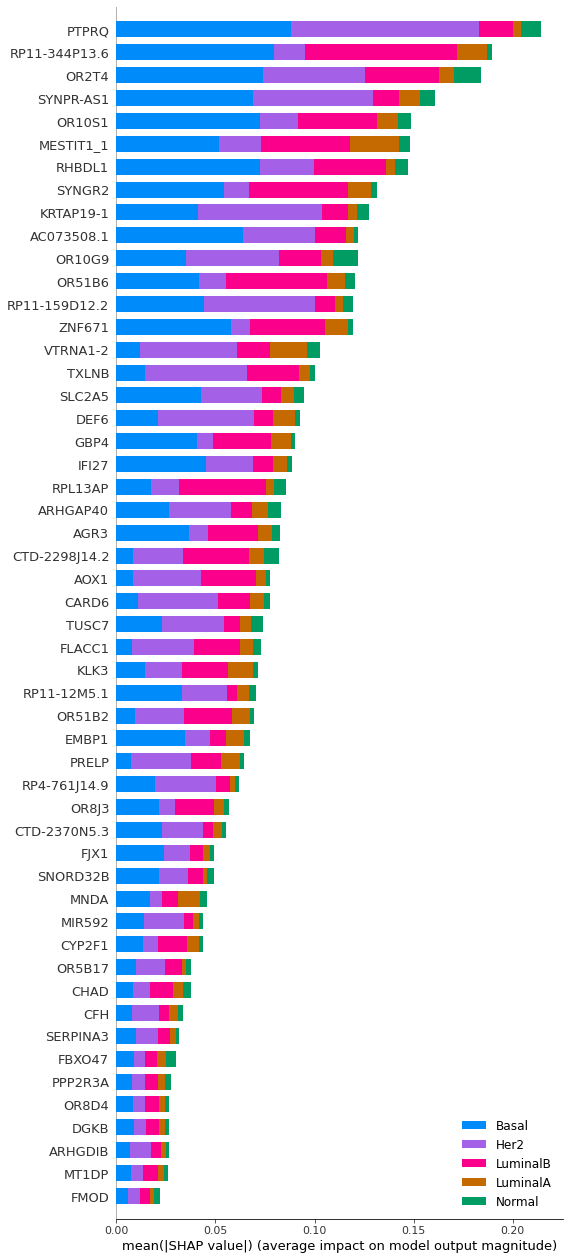

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names = genes_52, max_display=250, class_names=['Basal', 'Her2', 'LuminalA', 'LuminalB', 'Normal'], show=False)
plt.savefig('shap new/shap_all52.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
X_test0= np.asarray([X_test[i] for i in range(X_test.shape[0]) if Y_test[i] == 0 ])
index0= [i for i in range(X_test.shape[0]) if Y_test[i] == 0 ]
X_test1= np.asarray([X_test[i] for i in range(X_test.shape[0]) if Y_test[i] == 1 ])
index1= [i for i in range(X_test.shape[0]) if Y_test[i] == 1 ]
X_test2= np.asarray([X_test[i] for i in range(X_test.shape[0]) if Y_test[i] == 2 ])
index2= [i for i in range(X_test.shape[0]) if Y_test[i] == 2 ]
X_test3= np.asarray([X_test[i] for i in range(X_test.shape[0]) if Y_test[i] == 3 ])
index3= [i for i in range(X_test.shape[0]) if Y_test[i] == 3 ]
X_test4= np.asarray([X_test[i] for i in range(X_test.shape[0]) if Y_test[i] == 4 ])
index4= [i for i in range(X_test.shape[0]) if Y_test[i] == 4 ]



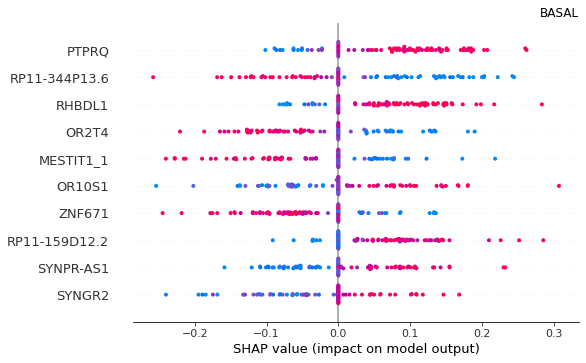

In [ ]:
shap.summary_plot(shap_values[0][index0], np.asarray(X_test0), feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("BASAL", loc='right')
plt.savefig('shap new/shap_basal_onlyBasalPatients.png', dpi=600, bbox_inches='tight')
plt.show()

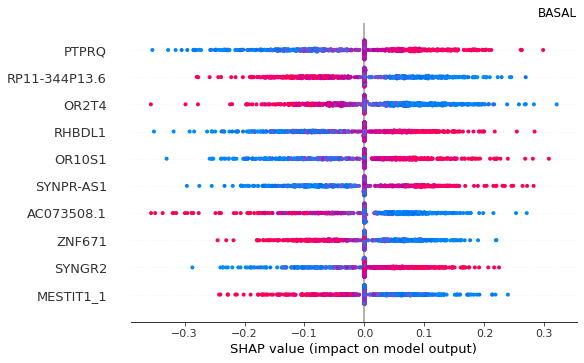

In [ ]:
shap.summary_plot(shap_values[0], X_test, feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("BASAL", loc='right')
plt.savefig('shap new/shap_basal_allPatients.png', dpi=600, bbox_inches='tight')
plt.show()

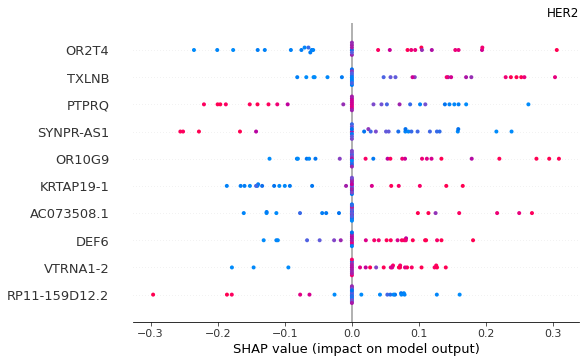

In [ ]:
shap.summary_plot(shap_values[1][index1], np.asarray(X_test1), feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("HER2", loc='right')
plt.savefig('shap new/shap_her2_onlyHer2Patients.png', dpi=600, bbox_inches='tight')
plt.show()

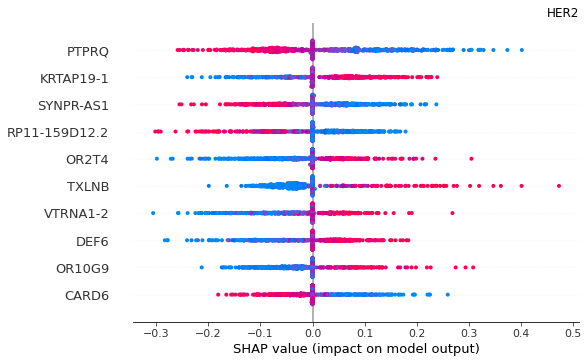

In [ ]:
shap.summary_plot(shap_values[1], X_test, feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("HER2", loc='right')
plt.savefig('shap new/shap_her2_allPatients.png', dpi=600, bbox_inches='tight')
plt.show()

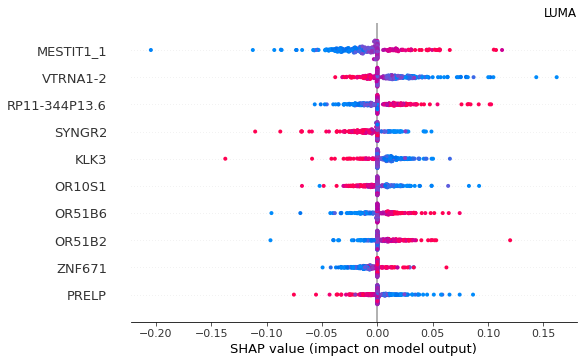

In [ ]:
shap.summary_plot(shap_values[2][index2], np.asarray(X_test2), feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("LUMA", loc='right')
plt.savefig('shap new/shap_lumA_onlyLumAPatients.png', dpi=600, bbox_inches='tight')
plt.show()

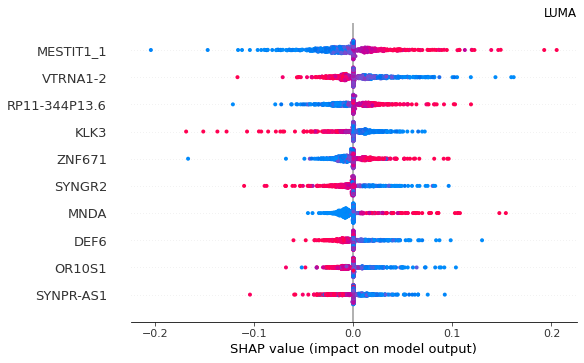

In [ ]:
shap.summary_plot(shap_values[2], X_test, feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("LUMA", loc='right')
plt.savefig('shap new/shap_lumA_allPatients.png', dpi=600, bbox_inches='tight')
plt.show()

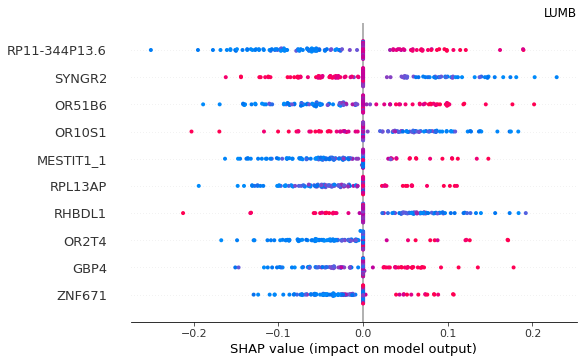

In [ ]:
shap.summary_plot(shap_values[3][index3], np.asarray(X_test3), feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("LUMB", loc='right')
plt.savefig('shap new/shap_lumB_onlyLumBPatients.png', dpi=600, bbox_inches='tight')
plt.show()

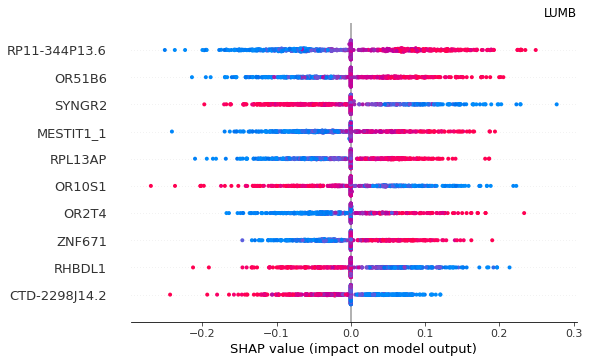

In [ ]:
shap.summary_plot(shap_values[3], X_test, feature_names = genes_52, max_display=10, show=False, color_bar=False)
plt.title("LUMB", loc='right')
plt.savefig('shap new/shap_lumB_allPatients.png', dpi=600, bbox_inches='tight')
plt.show()

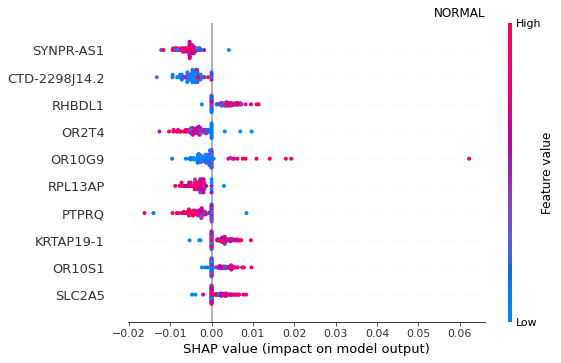

In [ ]:
shap.summary_plot(shap_values[4][index4], np.asarray(X_test4), feature_names = genes_52, max_display=10, show=False)
plt.title("NORMAL", loc='right')
plt.savefig('shap new/shap_normal_onlyNormalPatients.png', dpi=600, bbox_inches='tight')
plt.show()

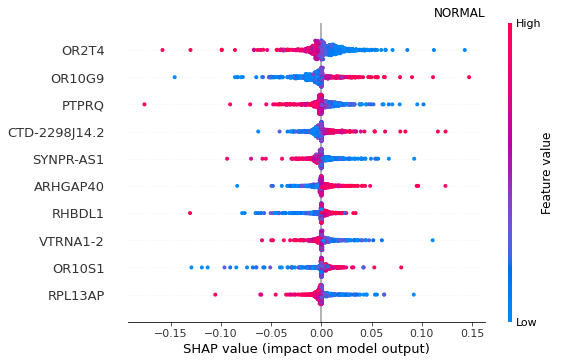

In [ ]:
shap.summary_plot(shap_values[4], X_test, feature_names = genes_52, max_display=10, show=False)
plt.title("NORMAL", loc='right')
plt.savefig('shap new/shap_normal_allPatients.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# acc confidence interval for 52 genes
import numpy as np
acc= np.asarray([0.7661290322580645, 0.7741935483870968, 0.8306451612903226, 0.8467741935483871, 0.8548387096774194])

print("acc : %0.3f (+/- %0.3f)" % (acc.mean(), acc.std() * 1.96))

acc : 0.815 (+/- 0.073)


In [ ]:
# acc confidence interval for all genes
import numpy as np
acc= np.asarray([0.8226, 0.7823, 0.7823, 0.7742, 0.7581])

print("acc : %0.3f (+/- %0.3f)" % (acc.mean(), acc.std() * 1.96))

acc : 0.784 (+/- 0.042)


In [ ]:

import numpy as np
c1=[[17,  0,  0,  0,  0],
 [ 1,  3,  0,  2,  0],
 [ 0,  1, 38, 12,  6],
 [ 1,  0,  5, 20,  0],
 [ 0,  0,  1,  0, 17]]
             
c2=[[16,  1,  0,  0,  0],
 [ 0,  4,  0,  2,  0],
 [ 0, 0, 47,  8,  2],
 [ 0,  1, 14, 11,  0],
 [ 0,  0,  0,  0, 18]]
 

c3=[[18,  0,  0,  0,  0],
 [ 1,  5,  0,  0,  0],
 [ 0,  0, 47, 10,  1],
 [ 0,  0,  7, 18,  0],
 [ 1,  0,  1,  0, 15]]

c4=[[17,  0,  1,  0,  0],
 [ 1,  4,  0,  0,  1],
 [ 0,  0, 47,  9,  2],
 [ 0,  1,  3, 21,  0],
 [ 1,  0,  0,  0, 16]]
 

c5 =[[15,  0,  0,  0,  2],
 [ 0,  7,  0,  0,  0],
 [ 0,  0, 49,  6,  3],
 [ 0,  0,  6, 19,  0],
 [ 1,  0,  0,  0, 16]]
c = np.asarray(c1)+ np.asarray(c2)+ np.asarray(c3)+ np.asarray(c4)+ np.asarray(c5)

In [ ]:
precision1 = []
precision2 = []
precision3 =[]
precision4=[]
precision5 =[]
recall1 =[]
recall2= []
recall3=[]
recall4=[]
recall5=[]
f1score1 =[]
f1score2 =[]
f1score3 =[]
f1score4 =[]
f1score5 =[]

for i in range(1,6):
   conf = eval("c"+str(i))
   for j in range(1,6):
        p=eval("precision"+str(j))
        r=eval("recall"+str(j))
        f=eval("f1score"+str(j))
        p1=conf[j-1][j-1]/sum(conf[j-1][k] for k in range(0,5) )
        r1=conf[j-1][j-1]/sum(conf[k][j-1] for k in range(0,5))
        #print(p1,r1)
        p.append(p1)
        r.append(r1)
        f.append((2*p1*r1)/(p1+r1))


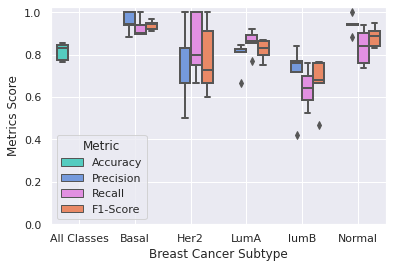

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()#style="whitegrid")
import pandas as pd
result = [                
                       ['Precision',precision1], 
                       ['Precision',precision2],
                       ['Precision',precision3],
                       ['Precision',precision4],
                       ['Precision',precision5],

                       ['Recall',recall1], 
                       ['Recall',recall2],
                       ['Recall',recall3],
                       ['Recall',recall4],
                       ['Recall',recall5],

                       ['F1-Score',f1score1], 
                       ['F1-Score',f1score2],
                       ['F1-Score',f1score3],
                       ['F1-Score',f1score4],
                       ['F1-Score',f1score5]              ]
#result = np.asarray(result)
#print(result, result.size)



xLabels = ['Basal']*5 + ['Her2']*5 + ['LumA']*5 +['lumB']*5 +['Normal']*5
xLabels  = ['All Classes']*5+xLabels * 3

finalResult  = pd.DataFrame({ 'Metric': ['Accuracy']*5+[i[0] for i in result for j in range(5)], 
                             'value':[0.7661290322580645, 0.7741935483870968, 0.8306451612903226, 0.8467741935483871, 0.8548387096774194]+[j for i in result for j in i[1]], 'Labels': xLabels })
           
my_pal = {"Accuracy": "turquoise", "Precision": "cornflowerblue", "Recall":"violet", "F1-Score": "coral"}


ax = sns.boxplot(x= "Labels", y = "value", hue = "Metric"  , data = finalResult, linewidth=2, orient="v", palette=my_pal)

plt.ylabel('Metrics Score')
plt.xlabel('Breast Cancer Subtype')
plt.ylim(0.0,1.025)
ax.xaxis.grid(True)
#plt.savefig('figures/boxPlot.png', dpi = 600)


In [ ]:
fiveFold52Genes = [0.7661290322580645, 0.7741935483870968, 0.8306451612903226, 0.8467741935483871, 0.8548387096774194]


<Figure size 432x288 with 0 Axes>

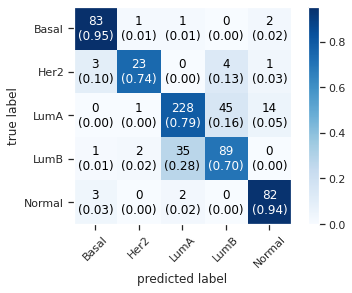

In [ ]:
from matplotlib import pyplot as plt
!pip install mlxtend --upgrade --no-deps
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=c,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True, class_names = ['Basal', 'Her2', 'LumA', 'LumB', 'Normal'])

#plt.show()
plt.savefig('figures/CM_methyl.png', bbox_inches = 'tight', dpi = 600)

{'Basal': {'precision': 0.9222222222222223, 'recall': 0.9540229885057471, 'f1-score': 0.9378531073446328, 'support': 87}, 'Her2': {'precision': 0.8518518518518519, 'recall': 0.7419354838709677, 'f1-score': 0.7931034482758621, 'support': 31}, 'LumA': {'precision': 0.8571428571428571, 'recall': 0.7916666666666666, 'f1-score': 0.8231046931407942, 'support': 288}, 'LumB': {'precision': 0.644927536231884, 'recall': 0.7007874015748031, 'f1-score': 0.6716981132075472, 'support': 127}, 'Normal': {'precision': 0.8282828282828283, 'recall': 0.9425287356321839, 'f1-score': 0.8817204301075269, 'support': 87}, 'accuracy': 0.8145161290322581, 'macro avg': {'precision': 0.8208854591463286, 'recall': 0.8261882552500737, 'f1-score': 0.8214959584152727, 'support': 620}, 'weighted avg': {'precision': 0.8184907850966756, 'recall': 0.8145161290322581, 'f1-score': 0.8149176075109626, 'support': 620}}


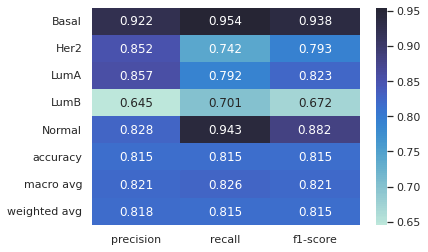

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
y_true=np.asarray([0]*(87)+[1] *(31)+[2]*(288)+[3]*(127)+ [4]*(87))
y_pred = np.asarray([0]*83+[1]*1+[2]*1+[3]*0+[4]*2+
                    [0]*3+[1]*23+[2]*0+[3]*4+[4]*1+
                    [0]*0+[1]*1+[2]*228+[3]*45+[4]*14+
                    [0]*1+[1]*2+[2]*35+[3]*89+[4]*0+  
                    [0]*3+[1]*0+[2]*2+[3]*0+[4]*82)
print(classification_report(y_true, y_pred, target_names=['Basal', 'Her2', 'LumA', 'LumB', 'Normal'],digits=5,output_dict=True))
clf_report=classification_report(y_true, y_pred, target_names=['Basal', 'Her2', 'LumA', 'LumB', 'Normal'],digits=5,output_dict=True)


import pandas as pd

fig = plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, fmt='.3g', center = True)
plt.savefig('figures/Heatmap.png',dpi=600, bbox_inches = "tight")

plt.show()